In [1]:
# Import Pytorch and Matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check torch version
torch.__version__

'2.5.1'

### Now write device agnostic code
- This means if we've got access to a GPU, our code will use it (for potentially faster computing).
- If no GPU is available, the code will default to using CPU.

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## 1. Data

In [3]:
# Create some data using simple linear regression formula : y = weight * X + bias (same as y=mX+C)

# First fix the weight & bias
weight = 0.7
bias =  0.3

# create the ranges
start = 0
end = 1
step = 0.02

X = torch.arange(start , end, step).unsqueeze(dim=1) # unsqueeze the data in axis 1 so that it did not give the error in computing
y = weight * X + bias

# print first 10 values
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# We have the data. Now we hve to split data into train and test. we split them  in 80-20 format (train=80%; test=20%)

# split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# length of the train and test data
len(X_train), len(X_test), len(y_train), len(y_test)


(40, 10, 40, 10)

In [5]:
# Now we want to visualize the train and test data compare the predictions

def plot_train_test_pred(train_data=X_train,
                         train_labels=y_train,
                         test_data=X_test,
                         test_labels=y_test,
                         pred=None):
    """
    Plots training data, test data and compares predictions.
    """

    # plot the train data
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

    #plot the test data
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test Data')


    if pred is not None:
        plt.scatter(test_data, pred, c='r', s=4, label='Predictions')

    # Show the legend
    plt.legend(prop={"size": 14})

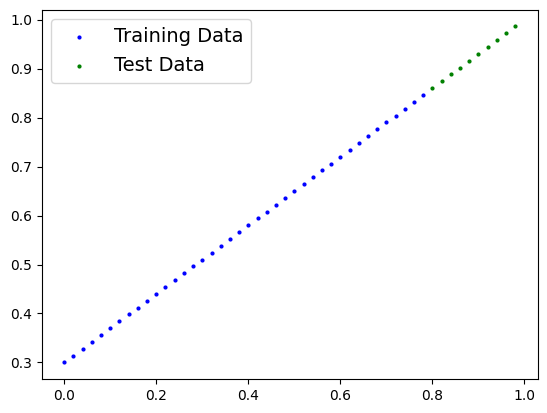

In [6]:
plot_train_test_pred()

## 2. Building a PyTorch Linear Model

In [7]:
# now we create the Linear Regression Model by subclassing nn.Module module

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # using nn.Linear() to create the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1) # as our feature 1 and ouotput is also 1 

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


# Create manual seed 
torch.manual_seed(42)

# Create model instance
model_1 = LinearRegressionModelV2()

model_1, model_1.state_dict(), next(model_1.parameters())

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]),
 Parameter containing:
 tensor([[0.7645]], requires_grad=True))

In [8]:
# Check the model device
next(model_1.parameters()).device

device(type='cpu')

In [9]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [10]:
!nvidia-smi

Sun Jan 26 17:00:24 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P0              N/A /  16W |     95MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

## 3. Training
For the training we need the following steps
- Loss Function
- Optimizer
- Training Loop
- Testing Loop

In [12]:
# Create loss function
loss_fn = nn.L1Loss()

# Create Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)


In [14]:
# Now write the Training loop

# setup the seed
torch.manual_seed(42)

# setup the epochs
epochs = 200

# put the data on device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    # start with train()
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    train_loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform Backpropagation (always on loss)
    train_loss.backward()

    # 5. Optimizer step -> gradient descent
    optimizer.step()

    ### Testing Loop

    # always start with eval()
    model_1.eval()

    with torch.inference_mode():
        
        # 1. Forward pass
        test_pred = model_1(X_test)

        # 2. Test Loss
        test_loss = loss_fn(test_pred, y_test)
    
    # print out the result
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss.cpu().detach().numpy())
        test_loss_values.append(test_loss.cpu().detach().numpy())
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5436570048332214 | Test loss: 0.560505211353302
Epoch: 10 | Train Loss: 0.42844706773757935 | Test loss: 0.42579540610313416
Epoch: 20 | Train Loss: 0.31323719024658203 | Test loss: 0.2910855710506439
Epoch: 30 | Train Loss: 0.1980273425579071 | Test loss: 0.15637575089931488
Epoch: 40 | Train Loss: 0.0828174576163292 | Test loss: 0.021665919572114944
Epoch: 50 | Train Loss: 0.023356428369879723 | Test loss: 0.04883447289466858
Epoch: 60 | Train Loss: 0.019609849900007248 | Test loss: 0.04538799077272415
Epoch: 70 | Train Loss: 0.01618141122162342 | Test loss: 0.03711546212434769
Epoch: 80 | Train Loss: 0.012742983177304268 | Test loss: 0.028842901811003685
Epoch: 90 | Train Loss: 0.00930792186409235 | Test loss: 0.02125724032521248
Epoch: 100 | Train Loss: 0.005878167692571878 | Test loss: 0.012984705157577991
Epoch: 110 | Train Loss: 0.0024393596686422825 | Test loss: 0.004712170455604792
Epoch: 120 | Train Loss: 0.010256479494273663 | Test loss: 0.0003308177

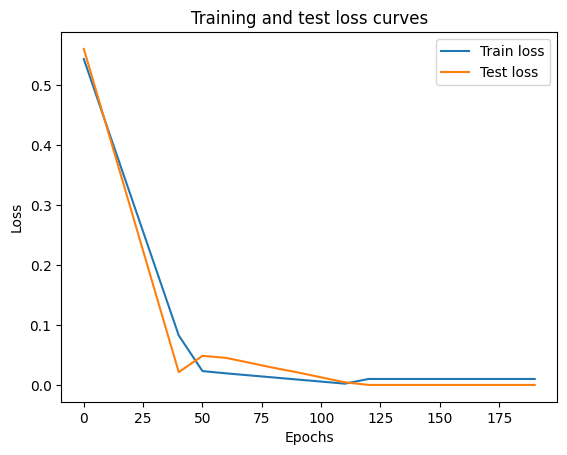

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [18]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

In [19]:
weight, bias

(0.7, 0.3)

### Making and Evaluating Predictions

In [20]:
# first eval mode
model_1.eval()

with torch.inference_mode():
    y_pred_new = model_1(X_test)
y_pred_new

tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]], device='cuda:0')

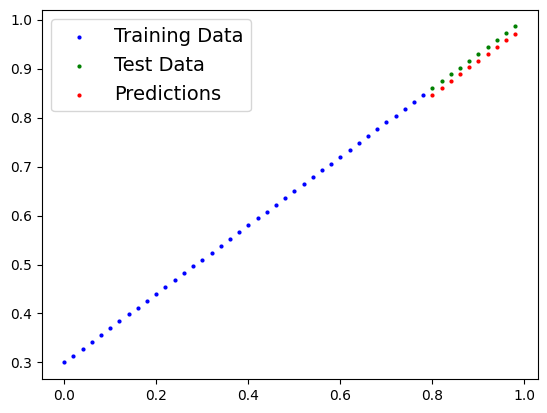

In [21]:
# Visualize the prediction
plot_train_test_pred(pred=y_pred_new.cpu())

## Saving and Loading the Model
- Save the parameters
- Load the model

In [22]:
# Create directory and file for saving the model

from pathlib import Path

# Create Model Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create Model Save Path
MODEL_NAME = "01_pytorch_workflow_SimpleLRMV2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_SimpleLRMV2.pth


In [23]:
### Load the Model

# start with creating model instance
loaded_model_1 = LinearRegressionModelV2()

# load the saved model state dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# put the loaded model to the device
loaded_model_1.to(device)

/tmp/ipykernel_191750/2304840694.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [24]:
# checking the loaded model device
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [25]:
# loaded models state dict
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

In [26]:
# Evaluated Model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_pred = loaded_model_1(X_test)
y_pred_new == loaded_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')